### Importing the dataset

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv('Final_AA.csv')
dataset = dataset.drop(['Headlines', 'Descriptions', 'Authors', 'Published_Dates', 'Publication', 'category', 'Keywords', 'Summaries', 'Source_URLs'], axis=1).dropna().reset_index(drop=True)
dataset.head()

,Articles
0,The contributors father was a member of Alcoho...
1,Image copyright Getty Images Alcoholics Anonym...
2,Image caption The true nature of alcoholism is...
3,Image copyright Other Image caption An AA meet...
4,Image copyright Thinkstock Everybody thinks th...


### Preliminary text exploration
Before we proceed with any text pre-processing, it is advisable to quickly explore the dataset in terms of word counts, most common and most uncommon words.

### Fetch word count for each abstract

In [3]:
#Fetch wordcount for each abstract
dataset['word_count'] = dataset['Articles'].apply(lambda x: len(str(x).split(" ")))
dataset[['Articles','word_count']].head()

,Articles,word_count
0,The contributors father was a member of Alcoho...,121
1,Image copyright Getty Images Alcoholics Anonym...,372
2,Image caption The true nature of alcoholism is...,952
3,Image copyright Other Image caption An AA meet...,1580
4,Image copyright Thinkstock Everybody thinks th...,1223


In [4]:
## Descriptive statistics of word counts
dataset.word_count.describe()

count      876.000000
mean       685.986301
std        906.872987
min          4.000000
25%        214.750000
50%        478.000000
75%        906.000000
max      14812.000000
Name: word_count, dtype: float64

The average word count is about 685 words per article. The word count ranges from a minimum of 4 to a maximum of 14812. The word count is important to give us an indication of the size of the dataset that we are handling as well as the variation in word counts across the rows.

### Most common and uncommon words
A peek into the most common words gives insights not only on the frequently used words but also words that could also be potential data specific stop words. A comparison of the most common words and the default English stop words will give us a list of words that need to be added to a custom stop word list.

In [5]:
#Identify common words
freq = pd.Series(' '.join(dataset['Articles']).split()).value_counts()[:10]
freq

the     27414
of      16226
to      15898
and     14967
a       12865
in      10367
is       5898
for      5617
that     4848
was      4793
dtype: int64

In [6]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(dataset 
         ['Articles']).split()).value_counts()[-10:]
freq1

incompetence      1
Bayshill          1
Biff,"            1
first-team        1
Vice-             1
Â“Prevention      1
514927            1
separate.         1
companies.Zuma    1
included:         1
dtype: int64

### Text Pre-processing

In [7]:
# Libraries for text preprocessing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
import re

**Removing stopwords**: Stop words include the large number of prepositions, pronouns, conjunctions etc in sentences. These words need to be removed before we analyse the text, so that the frequently used words are mainly the words relevant to the context and not common words used in the text.

There is a default list of stopwords in python nltk library. In addition, we might want to add context specific stopwords for which the “most common words” that we listed in the beginning will be helpful. We will now see how to create a list of stopwords and how to add custom stopwords:

In [8]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

We will now carry out the pre-processing tasks step-by-step to get a cleaned and normalised text corpus:

In [ ]:
corpus = []
for i in range(0, dataset.word_count.count()):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['Articles'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

Let us now view an item from the corpus:

In [ ]:
#View corpus item
corpus[290]

'image copyright pa image caption prosecution lawyer told downpatrick crown court june ulster bank experienced computer malfunction system recovering alcoholic jailed four month stealing faulty ulster bank cash machine judge told peter anthony young hunter way ardglass deliberately taken advantage major glitch bank system almost four year ago meant customer could withdraw fund atm machine without affecting balance following check bank discovered money withdrawn young prosecution lawyer told downpatrick crown court june ulster bank experienced computer malfunction system following check ulster bank discovered young customer withdrawn account day said m ivers judge told separate withdrawal day question prosecution lawyer said bank made repeated attempt contact young without success eventually reporting incident police fraudulent psni started investigation young voluntarily attended police station admitted making withdrawal telling police spent money drink prosecution lawyer said accused 

### Data Exploration
We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words.

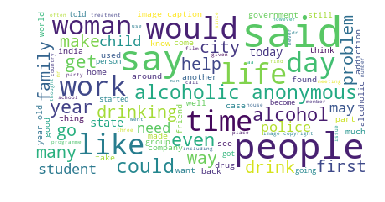

In [ ]:
#Word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from os import path

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=1000)

## Creating a vector of word counts

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [ ]:
list(cv.vocabulary_.keys())[:10]

### Visualize top N uni-grams, bi-grams & tri-grams
We can use the CountVectoriser to visualise the top 20 unigrams, bi-grams and tri-grams.

**Bar plot of most frequently occurring uni-grams**

In [ ]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["uni-grams", "Freq"]
print(top_df)

In [ ]:
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="uni-grams", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

**Bar plot of most frequently occurring bi-grams**

In [ ]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

In [ ]:
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

### Bar plot of most frequently occurring Tri-grams

In [ ]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

In [ ]:
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

### Converting to a matrix of integers

The next step of refining the word counts is using the TF-IDF vectoriser. The deficiency of a mere word count obtained from the countVectoriser is that, large counts of certain common words may dilute the impact of more context specific words in the corpus. This is overcome by the TF-IDF vectoriser which penalizes words that appear several times across the document. TF-IDF are word frequency scores that highlight words that are more important to the context rather than those that appear frequently across documents.

**TF-IDF consists of 2 components:**

- TF — term frequency

- IDF — Inverse document frequency

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[400]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

Based on the TF-IDF scores, we can extract the words with the highest scores to get the keywords for a document.

In [ ]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])